### This notebook will be used to analyze the results collected from the website developed, with the game to guess player's positions

##### First, we'll read the csvs

In [59]:
import pandas as pd
from scipy.stats import entropy
import numpy as np
import matplotlib.pyplot as plt

In [60]:
predictions = pd.read_csv('NBA - Predictions.csv', index_col=0)
predictions.drop(columns=["Createdat"], inplace=True)
feedbacks = pd.read_csv('NBA - UserFeedbacks.csv')
tutorial = pd.read_csv('NBA - Tutorial.csv', index_col=0)
results = pd.read_csv('NBA - Results.csv', index_col=0)
results.drop(columns=["Createdat"], inplace=True)

#### Now, let's join these dfs based on the user

In [70]:
# Rename columns for consistency
predictions.rename(columns={'User': 'User', 'Userattempt': 'Attempt'}, inplace=True)
results.rename(columns={'User': 'User', 'Attempt': 'Attempt'}, inplace=True)
tutorial.rename(columns={'User': 'User', 'Att': 'Attempt'}, inplace=True)

# Convert 'Attempt' column to numeric, handling errors
predictions['Attempt'] = pd.to_numeric(predictions['Attempt'], errors='coerce')
results['Attempt'] = pd.to_numeric(results['Attempt'], errors='coerce')
tutorial['Attempt'] = pd.to_numeric(tutorial['Attempt'], errors='coerce')

# Merge predictions and results
merged_df = pd.merge(predictions, results, on=['User', 'Attempt'], how='left')

# Merge with tutorial
final_df = pd.merge(merged_df, tutorial, on=['User', 'Attempt'], how='left')

In [63]:
final_df[final_df['Passed']]['Correct'].mean()

np.float64(0.5008517887563884)

In [74]:
guesses_by_tutorial_status = final_df['Passed'].value_counts()
guesses_by_tutorial_status[True] / len(final_df.index)

np.float64(0.7115384615384616)

In [47]:
def extract_player_info(player_string):
    try:
        player, position_season = player_string.split('-')
        position, season = position_season.split('(')
        season = season[:-1]  # Remove the closing parenthesis
        return player, position, season
    except:
        return None, None, None


In [48]:
final_df[['Player', 'Real Position', 'Season']] = final_df['Player'].apply(lambda x: pd.Series(extract_player_info(x)))

final_df.dropna(axis=0, how='any', inplace=True)
final_df.reset_index(drop=True, inplace=True)

In [49]:
final_df

,Player,User,Attempt,Position,Correct,Tries,SuccessRate,Level,Passed,Real Position,Season
0,VladeDivac,João,1,PF,False,10.0,30.0,Basic,True,C,2004
1,CodyZeller,juulfs,1,PG,False,10.0,30.0,Basic,False,C,2018
2,CobyWhite,juulfs,1,SG,False,10.0,30.0,Basic,False,PG,2020
3,HerbWilliams,juulfs,1,SF,False,10.0,30.0,Basic,False,C,1984
4,NemanjaBjelica,juulfs,1,PF,True,10.0,30.0,Basic,False,PF,2020
...,...,...,...,...,...,...,...,...,...,...,...
1635,JermaineO'Neal,matheus,3,C,True,10.0,50.0,Advanced,False,C,2009
1636,DannySchayes,matheus,3,C,True,10.0,50.0,Advanced,False,C,1987
1637,LouWilliams,matheus,3,PG,False,10.0,50.0,Advanced,False,SG,2019
1638,CoryAlexander,matheus,3,PG,True,10.0,50.0,Advanced,False,PG,1999


### Relation between position and efficacy for each user

Entropy of Guesses per Real Position:
Real Position
C     1.418310
PF    2.068363
PG    1.818029
SF    2.112762
SG    2.027738
Name: count, dtype: float64


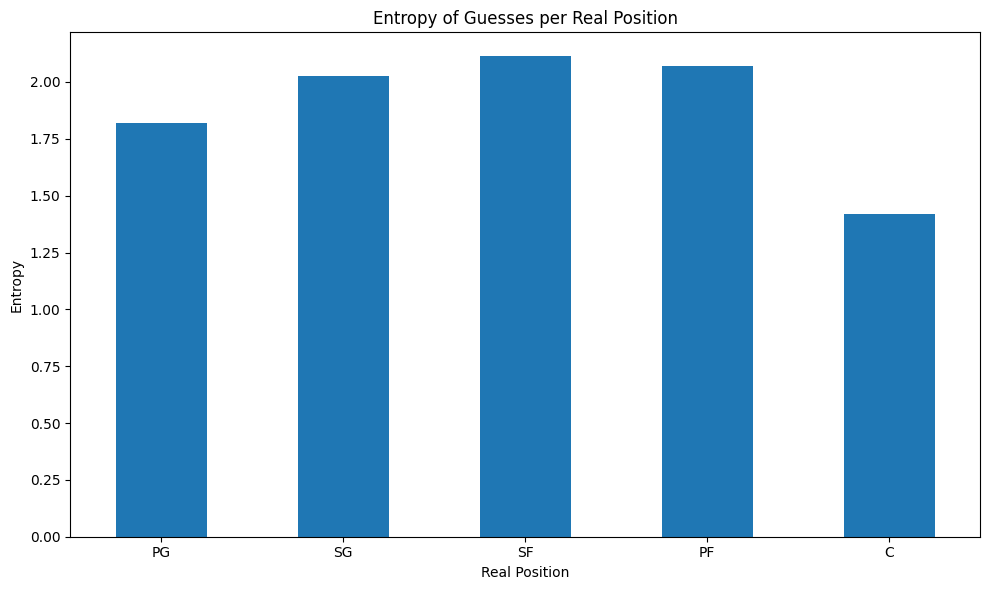

In [50]:
guess_distribution_by_pos = final_df.groupby('Real Position')['Position'].value_counts()

# Normalize the counts to get probabilities for each real position's guesses.
guess_probabilities_by_pos = guess_distribution_by_pos.groupby(level=0).apply(lambda x: x / x.sum())

# Calculate the entropy for each real position's guess distribution.
position_entropy = guess_probabilities_by_pos.groupby(level=0).apply(lambda p: entropy(p, base=2))

print("Entropy of Guesses per Real Position:")
print(position_entropy)

# Define the desired order of positions
desired_order = ['PG', 'SG', 'SF', 'PF', 'C']

# Reindex the Series to match the desired order
position_entropy = position_entropy.reindex(desired_order)

# Plotting the entropy for better visualization
plt.figure(figsize=(10, 6))
position_entropy.plot(kind='bar')
plt.xlabel('Real Position')
plt.ylabel('Entropy')
plt.title('Entropy of Guesses per Real Position')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

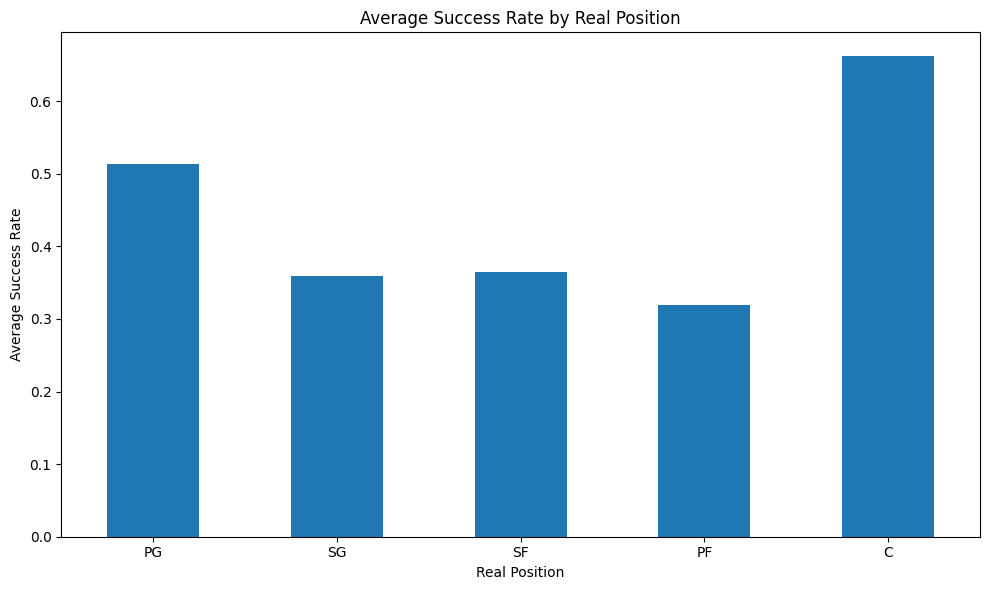

In [51]:
import matplotlib.pyplot as plt

# Calculate average success rate by real position
correct_guesses_by_position = final_df.groupby('Real Position')['Correct'].sum()
total_guesses_by_position = final_df.groupby('Real Position')['Correct'].count()

success_rate_by_position = correct_guesses_by_position / total_guesses_by_position

# Define the desired order of positions
desired_order = ['PG', 'SG', 'SF', 'PF', 'C']

# Reindex the Series to match the desired order
success_rate_by_position = success_rate_by_position.reindex(desired_order)

plt.figure(figsize=(10, 6))
success_rate_by_position.plot(kind='bar')
plt.xlabel('Real Position')
plt.ylabel('Average Success Rate')
plt.title('Average Success Rate by Real Position')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

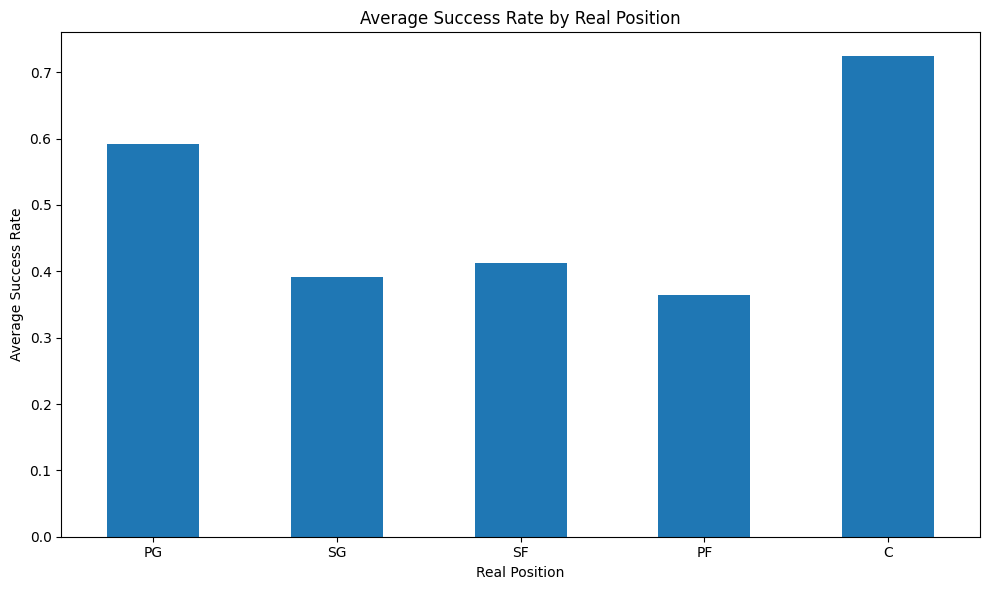

In [52]:
import matplotlib.pyplot as plt

# Calculate average success rate by real position
fdf = final_df[final_df['Passed']]
correct_guesses_by_position = fdf.groupby('Real Position')['Correct'].sum()
total_guesses_by_position = fdf.groupby('Real Position')['Correct'].count()

success_rate_by_position = correct_guesses_by_position / total_guesses_by_position

# Define the desired order of positions
desired_order = ['PG', 'SG', 'SF', 'PF', 'C']

# Reindex the Series to match the desired order
success_rate_by_position = success_rate_by_position.reindex(desired_order)

plt.figure(figsize=(10, 6))
success_rate_by_position.plot(kind='bar')
plt.xlabel('Real Position')
plt.ylabel('Average Success Rate')
plt.title('Average Success Rate by Real Position')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### How does the season relate to user efficacy

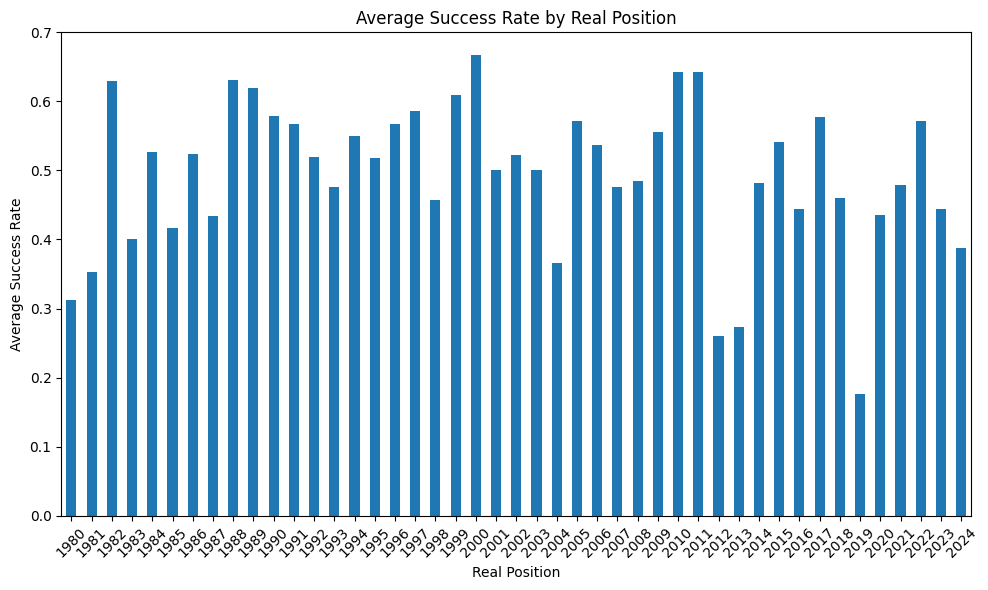

In [53]:
import matplotlib.pyplot as plt

# Calculate average success rate by real position
correct_guesses_by_season = fdf.groupby('Season')['Correct'].sum()
total_guesses_by_season = fdf.groupby('Season')['Correct'].count()
success_rate_by_season = correct_guesses_by_season / total_guesses_by_season

plt.figure(figsize=(10, 6))
success_rate_by_season.plot(kind='bar')
plt.xlabel('Real Position')
plt.ylabel('Average Success Rate')
plt.title('Average Success Rate by Real Position')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Repeat grouping in intervals of 5

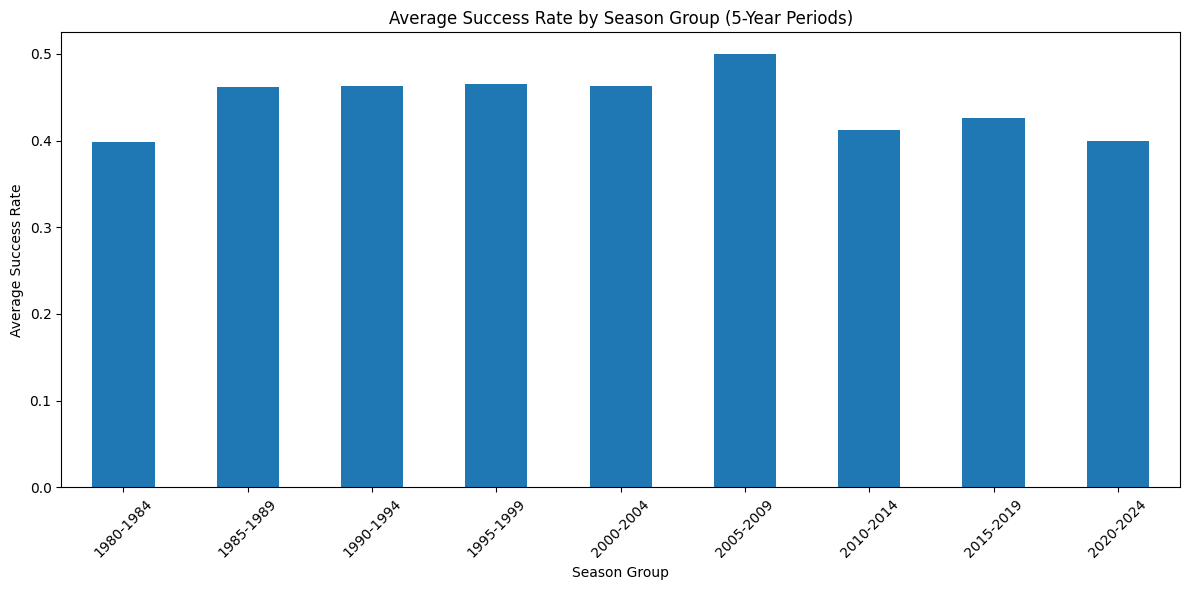

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming final_df is already loaded and 'Season' column exists

# Convert 'Season' to numeric if it's not already
final_df['Season'] = pd.to_numeric(final_df['Season'], errors='coerce')

# Define a function to group seasons into 5-year periods
def group_seasons(season):
    return f'{season // 5 * 5}-{season // 5 * 5 + 4}'

# Apply the grouping function to create a new 'Season Group' column
final_df['Season Group'] = final_df['Season'].apply(group_seasons)

# Calculate average success rate by season group
correct_guesses_by_season_group = final_df.groupby('Season Group')['Correct'].sum()
total_guesses_by_season_group = final_df.groupby('Season Group')['Correct'].count()
success_rate_by_season_group = correct_guesses_by_season_group / total_guesses_by_season_group

# Plot the results
plt.figure(figsize=(12, 6))
success_rate_by_season_group.plot(kind='bar')
plt.xlabel('Season Group')
plt.ylabel('Average Success Rate')
plt.title('Average Success Rate by Season Group (5-Year Periods)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

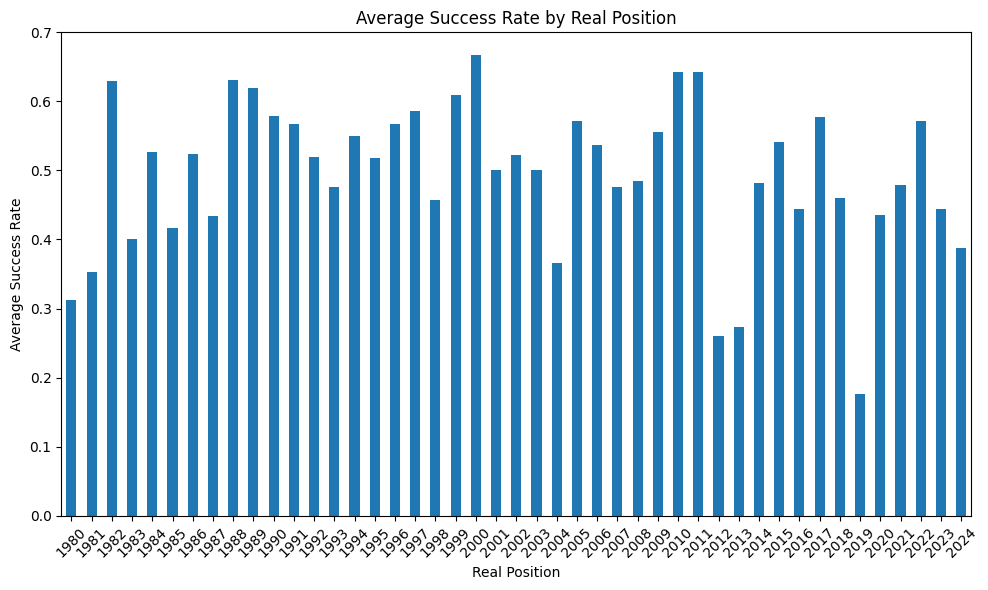

In [55]:
import matplotlib.pyplot as plt

# Calculate average success rate by real position
fdf = final_df[final_df['Passed']]
correct_guesses_by_season = fdf.groupby('Season')['Correct'].sum()
total_guesses_by_season = fdf.groupby('Season')['Correct'].count()
success_rate_by_season = correct_guesses_by_season / total_guesses_by_season

plt.figure(figsize=(10, 6))
success_rate_by_season.plot(kind='bar')
plt.xlabel('Real Position')
plt.ylabel('Average Success Rate')
plt.title('Average Success Rate by Real Position')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Repeat grouping in intervals of 5

C:\Users\mathe\AppData\Local\Temp\ipykernel_15244\337151593.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdf['Season'] = pd.to_numeric(fdf['Season'], errors='coerce')
C:\Users\mathe\AppData\Local\Temp\ipykernel_15244\337151593.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdf['Season Group'] = fdf['Season'].apply(group_seasons)


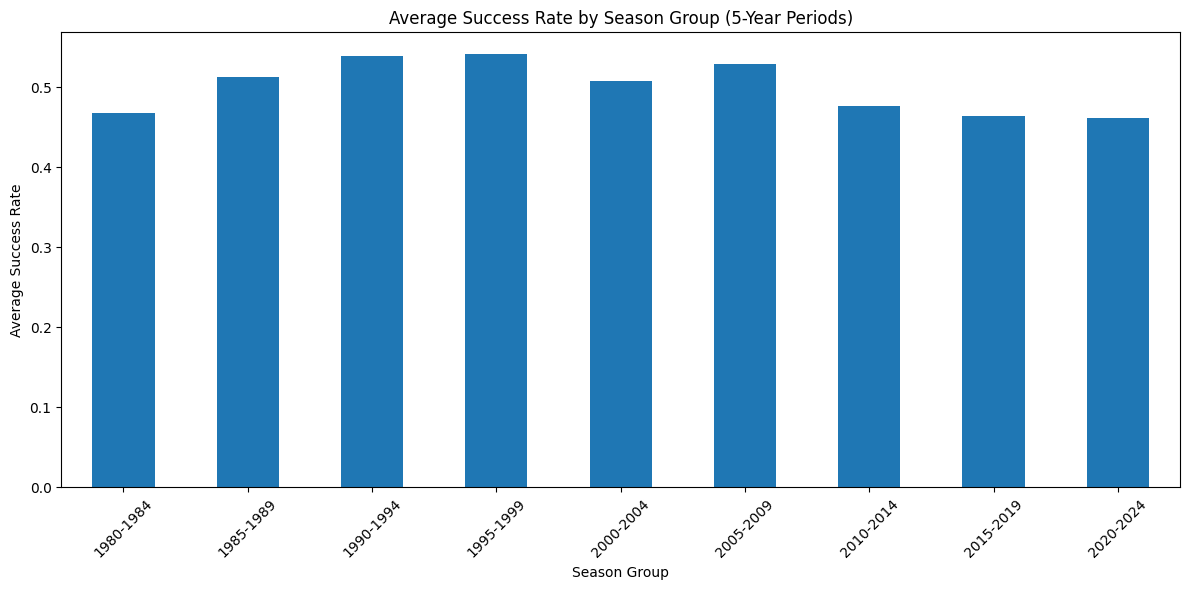

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming final_df is already loaded and 'Season' column exists

# Convert 'Season' to numeric if it's not already
fdf = final_df[final_df['Passed']]
fdf['Season'] = pd.to_numeric(fdf['Season'], errors='coerce')

# Define a function to group seasons into 5-year periods
def group_seasons(season):
    return f'{season // 5 * 5}-{season // 5 * 5 + 4}'

# Apply the grouping function to create a new 'Season Group' column
fdf['Season Group'] = fdf['Season'].apply(group_seasons)

# Calculate average success rate by season group
correct_guesses_by_season_group = fdf.groupby('Season Group')['Correct'].sum()
total_guesses_by_season_group = fdf.groupby('Season Group')['Correct'].count()
success_rate_by_season_group = correct_guesses_by_season_group / total_guesses_by_season_group

# Plot the results
plt.figure(figsize=(12, 6))
success_rate_by_season_group.plot(kind='bar')
plt.xlabel('Season Group')
plt.ylabel('Average Success Rate')
plt.title('Average Success Rate by Season Group (5-Year Periods)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

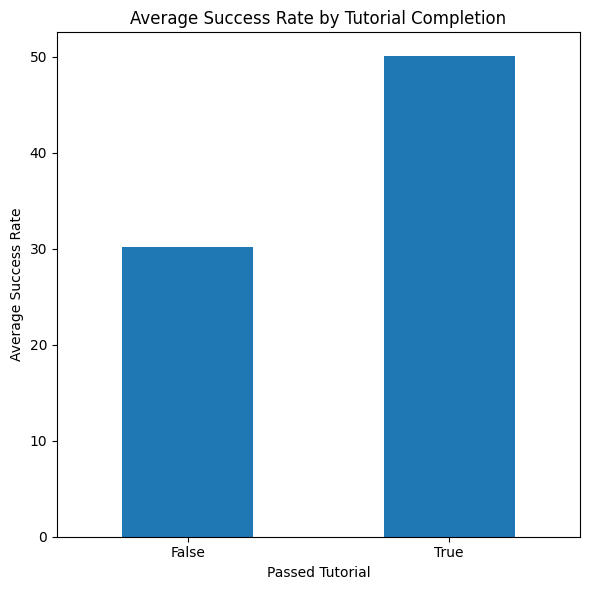

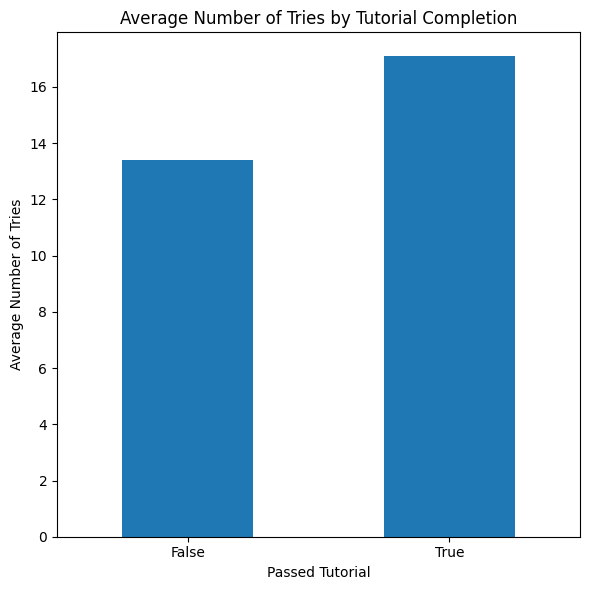

In [57]:
# Calculate average success rate by tutorial completion
success_rate_by_tutorial = final_df.groupby('Passed')['SuccessRate'].mean()

# Plot the results
plt.figure(figsize=(6, 6))
success_rate_by_tutorial.plot(kind='bar')
plt.xlabel('Passed Tutorial')
plt.ylabel('Average Success Rate')
plt.title('Average Success Rate by Tutorial Completion')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate average tries by tutorial completion
tries_by_tutorial = final_df.groupby('Passed')['Tries'].mean()

# Plot the results
plt.figure(figsize=(6, 6))
tries_by_tutorial.plot(kind='bar')
plt.xlabel('Passed Tutorial')
plt.ylabel('Average Number of Tries')
plt.title('Average Number of Tries by Tutorial Completion')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

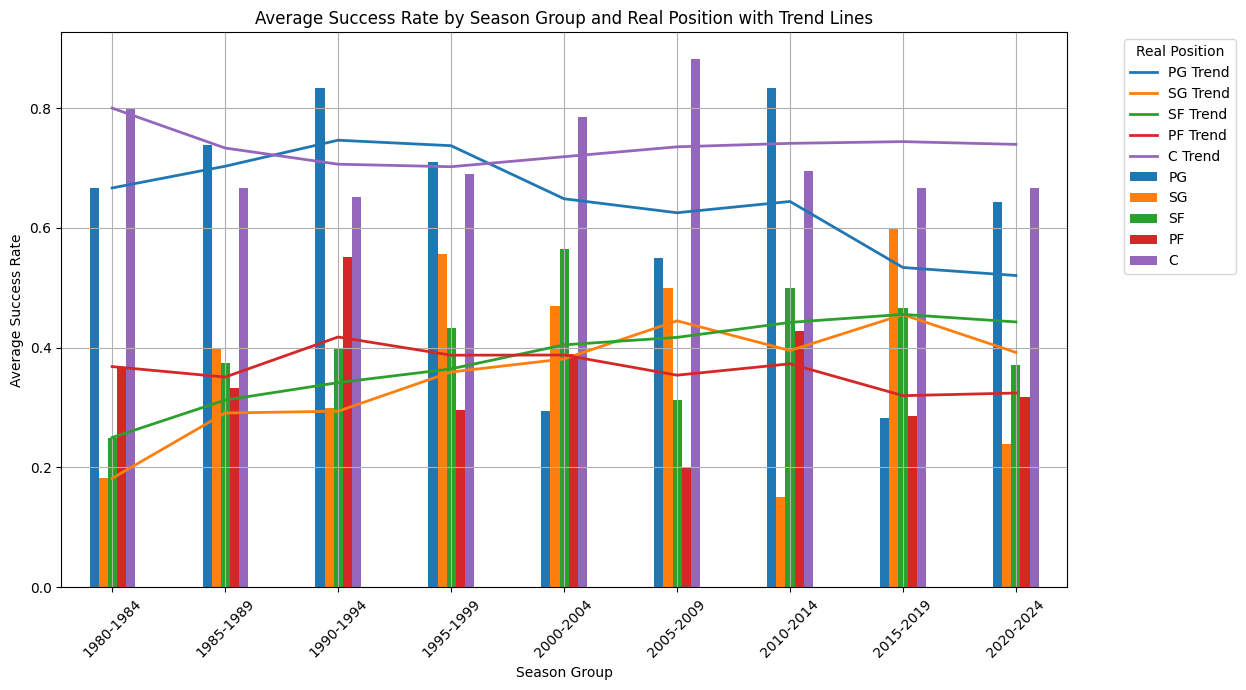

In [58]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming final_df is already loaded and 'Season' and 'Real Position' columns exist

# Convert 'Season' to numeric if it's not already
final_df['Season'] = pd.to_numeric(final_df['Season'], errors='coerce')

# Define a function to group seasons into 5-year periods
def group_seasons(season):
    return f'{season // 5 * 5}-{season // 5 * 5 + 4}'

# Apply the grouping function to create a new 'Season Group' column
final_df['Season Group'] = final_df['Season'].apply(group_seasons)

final_df = final_df[final_df['Passed']]

# Define the desired order of positions
desired_order = ['PG', 'SG', 'SF', 'PF', 'C']

# Group by both 'Season Group' and 'Real Position'
grouped = final_df.groupby(['Season Group', 'Real Position'])

# Calculate the number of correct guesses and total guesses for each group
correct_guesses = grouped['Correct'].sum()
total_guesses = grouped['Correct'].count()

# Calculate the success rate for each group
success_rate = correct_guesses / total_guesses

# Unstack the results to create a table with positions as columns and season groups as rows
success_rate_table = success_rate.unstack()

# Reindex the columns to match the desired order of positions
success_rate_table = success_rate_table.reindex(columns=desired_order)

# Calculate the moving average for each position
window_size = 5  # Increased window size for smoother lines
moving_averages = success_rate_table.rolling(window=window_size, min_periods=1).mean()  # Added min_periods=1

# Plot the results as a grouped bar chart
ax = success_rate_table.plot(kind='bar', figsize=(14, 7), position=0.5, width=0.4)  # Adjust bar positions and width

# Overlay the moving average lines
for position in desired_order:
    ax.plot(moving_averages.index, moving_averages[position], linestyle='-', marker='', linewidth=2, label=f'{position} Trend')

plt.xlabel('Season Group')
plt.ylabel('Average Success Rate')
plt.title('Average Success Rate by Season Group and Real Position with Trend Lines')
plt.xticks(rotation=45)
plt.legend(title='Real Position', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for the legend
plt.show()